In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import median
import matplotlib.pyplot as plt

from data_preprocessing import read_table, merge_str, load_trim_attr

warnings.filterwarnings('ignore')

# Identification of Gentrified Tracts in Melbourne, Australia

This notebook follows the definition by Lance Freeman to identify gentrified tracts in a given period of time. This concept is applied to Melbourne, Australia in 2 time periods: 2006-2016 and 2011-2016. All three census work with different definition of their geographic units thus making it vital to interpolate 2006 and 2011 geographic divisions to that of 2016. For this and other pre-processinf steps we employ the rest of notebooks located in the same folder.

# Table of Contents

1. [Central Areas](#central_areas)


2. [Disinvested Areas](#disinvested_areas)


3. [Educational Attainment as a Proxy of Class](#ed_attainment) 


4. [Low-Income Households](#li_hh)


5. [Reinvestment](#reinv)


6. [Results: Gentrification Classification](#results)


# 1. Central Areas <a name="central_areas"></a>

Tracts need to be located in the central city at the beginning of the intercensal period. Herein, we expand the analysis to all Greater Melbourne (defined by the Australian Bureau of Statistics).

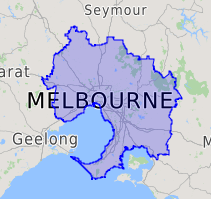

# 2. Disinvested Areas<a name="disinvested_areas"></a>

Desinvested areas are those which have a proportion of housing built within the past 20 years lower than the pro- portion found at the median for the respective metropolitan area. To calculate this we use the number of building permits by Statistical Local Areas and Statistical Area Level 2 provided by ABS within the past 10 years.

In [39]:
# Merge all years together

def merge_same_unit_files(same_unit_years, region_code, features):
    i=0
    while i < len(same_unit_years):
        if i == 0:
            data_all_years = pd.merge(same_unit_years[i], 
                                      same_unit_years[i+1], 
                                      how='right', 
                                      on=region_code)
            i = 2
        else:
            data_all_years = pd.merge(data_all_years, 
                                      same_unit_years[i], 
                                      how='right', 
                                      on=region_code)
            i = i+1
    return data_all_years[features + [region_code]]

In [40]:
# Median of the collection of all building permits in Local Statistical Areas

def median_concat_series(all_permits):
    years = all_permits.columns
    numbers = []
    for year in years:
        numbers = numbers + all_permits[year].tolist()
    return numbers

In [41]:
#Plot polygon shapefile with categoriacal variable

def plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col):
    shp = gpd.read_file(shp_path).to_crs(crs)
    shp_attr = merge_str (shp, attr_table, 
                          shp_pivot_col,
                          attr_pivot_col, 
                          how='right') 
    shp_attr.plot(column=attribute,legend=True, figsize=(20,10), categorical=True, cmap = 'PRGn')

In [42]:
# Load all yearly building permits files

common_path = 'Data/Gentrification_Labels/Disinvestment/Geopandas_Interpolated_SA1/'

df_05_06 = read_table(common_path +'BP_2005_2006.csv')
df_06_07 = read_table(common_path +'BP_2006_2007.csv')
df_07_08 = read_table(common_path +'BP_2007_2008.csv')
df_08_09 = read_table(common_path +'BP_2008_2009.csv')
df_09_10 = read_table(common_path +'BP_2009_2010.csv')
df_10_11 = read_table(common_path +'BP_2010_2011.csv')
df_11_12 = read_table(common_path +'BP_2011_2012.csv')
df_12_13 = read_table(common_path +'BP_2012_2013.csv')
df_13_14 = read_table(common_path +'BP_2013_2014.csv')
df_14_15 = read_table(common_path +'BP_2014_2015.csv')
df_15_16 = read_table(common_path +'BP_2015_2016.csv')

SA1_GM_2016 =  read_table('Data/Geographical_Units/Great_Melbourne_Units/SA1_2016_GM.csv')

In [43]:
# Calculate the median among all instances considering all years

features = ['BP_2005_2006','BP_2006_2007', 'BP_2007_2008','BP_2008_2009', 'BP_2009_2010', 'BP_2010_2011',
            'BP_2011_2012','BP_2012_2013', 'BP_2013_2014','BP_2014_2015', 'BP_2015_2016']

df_build_perms =  [df_05_06, df_06_07, df_07_08, df_08_09, df_09_10, df_10_11, 
                   df_11_12, df_12_13, df_13_14, df_14_15, df_15_16]

building_permits = merge_same_unit_files(df_build_perms,
                                         'SA1_MAINCO', 
                                         features)

series_build_perm = median_concat_series(building_permits[features])

disinv_threshold = median(series_build_perm)

print(disinv_threshold)

234.0


In [44]:
# Calculate binary label of "Disinvestment"

counter = 0
for col in building_permits.columns:
    if col in features:
        if counter == 0:
            building_permits['Average']= pd.to_numeric(building_permits[col])
        else:
            building_permits['Average']= building_permits['Average'] + pd.to_numeric(building_permits[col])
        counter = counter + 1
        
building_permits['Average']= building_permits['Average']/(counter)
building_permits['Disinvested'] = np.where(building_permits['Average']< disinv_threshold, True, False)

disinveted = len(building_permits[building_permits['Disinvested']==True])
non_disinvested = len(building_permits[building_permits['Disinvested']==False])
print('Number of disinvested tracts: {}'.format(disinveted))
print('Number of tracts with no disinvested: {}'.format(non_disinvested))

Number of disinvested tracts: 3936
Number of tracts with no disinvested: 6353


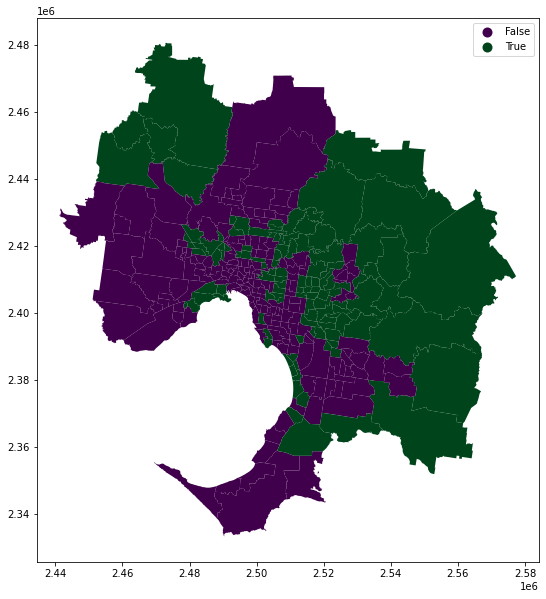

In [45]:
# Plot results

shp_path = 'Data/Shapefiles/Great_Melbourne/SA2_2016_GM/SA2_GreaterMelbourne.shp'
crs = 7899
attribute = 'Disinvested'
attr_table = SA2_all
attr_pivot_col = 'SA2_2016_A'
shp_pivot_col = 'SA2_2016_A'

plot_categorical_attr(shp_path, 
                      crs, 
                      attribute, 
                      attr_table, 
                      attr_pivot_col, 
                      shp_pivot_col)

In [46]:
#building_permits.to_csv('Data/Gentrification_Labels/Disinvestment/SA1_2016_disinv_outcome.csv',index=False)

# 3. Educational Atainment as Proxy of Class <a name="ed_attainment"></a>

Freeman implements the following rule: a neighborhood must have an increase in educational attainment, measured as the percentage of those 25 years and older with at least four years of college (an undergraduate degree in the US), greater than or equal to the average increase in educational attainment in the neighborhood’s respective metropolitan area. We refer to the Australian censuses of 2006, 2011 and 2016 disregarding the age requirement as it is not included in the datapacks of the last 2 censuses.

Data:
- Non_school_qualifications_Bachelor_Degree_Level_Persons (2011, 2016)
- University or other Tertiary Institutions: Full-time student: Aged 25 years and over,Persons (2006)
- University or other Tertiary Institutions: Part-time student: Aged 25 years and over,Persons (2006)
- University or other Tertiary Institutions: Full/Part-time student status not stated,Persons (2006)


In [47]:
# Function to do a binary classification given a threshold in a numerical feature

def mean_threshold_classify (start_attr_file_path, end_attr_file_path, filter_units_path, attr_name,
                             caclulated_name, start_columns, end_columns, code):
    #Calculate mean of the end date
    attr_end = load_trim_attr(end_attr_file_path, 
                              end_columns, 
                              filter_units_path, 
                              attr_name, 
                              code=code)
    end_mean = attr_end[attr_name].mean()
    
    #Calculate mean of the start date
    attr_start = load_trim_attr(start_attr_file_path, 
                                start_columns, 
                                filter_units_path, 
                                attr_name, 
                                code=code)
    start_mean = attr_start[attr_name].mean()
    
    #Calculate change of between dates
    threshold = (end_mean-start_mean)/end_mean
    
    #Allocate labels for attribute regarding threshold
    outcome = attr_start[[attr_start.columns[0]]]
    outcome['attr_start'] = attr_start[attr_name]
    outcome['attr_end'] = attr_end[attr_name]
    outcome['change'] = (outcome['attr_end']-outcome['attr_start'])/outcome['attr_start']
    outcome['change'] = outcome['change'].replace({np.inf: 0})
    outcome[caclulated_name] = np.where(outcome['change']> threshold, True, False)
    
    #Print results
    print('tracts with '+ caclulated_name + ' ' + str(len(outcome[outcome[caclulated_name] == True])))
    print('tracts without '+ caclulated_name + ' '  + str(len(outcome[outcome[caclulated_name] == False])))
    
    return outcome

## 2011-2016

In [50]:
filter_units_path = 'Data/Geographical_Units/Great_Melbourne_Units/SA1_2016_GM.csv'
end_attr_file_path = 'Data/Gentrification_Labels/Educational_Attainment/2016Census_G40_VIC_SA1.csv'
start_attr_file_path = 'Data/Gentrification_Labels/Educational_Attainment/Geopandas_Interpolated/' \
                       + 'Educational_Atainment_2011.csv'
attr_name = 'Educational_Atainment'
caclulated_name = 'Influx_affluent'
start_columns = [0,2]
end_columns = [0,39]

In [51]:
influx_affluent_11_16 = mean_threshold_classify(start_attr_file_path, 
                                                end_attr_file_path, 
                                                filter_units_path, 
                                                attr_name,
                                                caclulated_name,
                                                start_columns,
                                                end_columns,
                                                code=1)

tracts with Influx_affluent 7557
tracts without Influx_affluent 2732


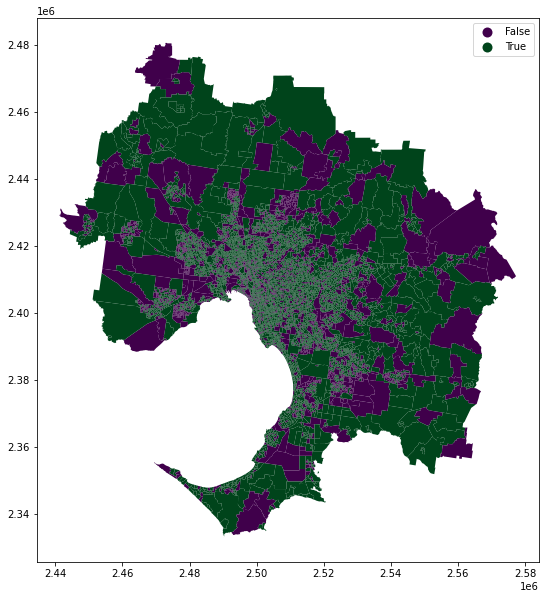

In [53]:
shp_path = 'Data/Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = caclulated_name
attr_table = influx_affluent_11_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

In [ ]:
#influx_affluent_11_16.to_csv('Data/Gentrification_Labels/Educational_Attainment/EA_11_16_SA1_outcome.csv',index=False)

## 2006-2016

In [54]:
filter_units_path = 'Data/Geographical_Units/Great_Melbourne_Units/SA1_2016_GM.csv'
end_attr_file_path = 'Data/Gentrification_Labels/Educational_Attainment/2016Census_G40_VIC_SA1.csv'
start_attr_file_path = 'Data/Gentrification_Labels/Educational_Attainment/Geopandas_Interpolated/' +\
                       'Educational_Atainment_2006.csv'
attr_name = 'Educational_Atainment'
caclulated_name = 'Influx_affluent'
start_columns = [1,2]
end_columns = [0,39]

In [55]:
influx_affluent_06_16 = mean_threshold_classify(start_attr_file_path, 
                                                end_attr_file_path, 
                                                filter_units_path, 
                                                attr_name,
                                                caclulated_name,
                                                start_columns,
                                                end_columns,
                                                code=1)

tracts with Influx_affluent 9587
tracts without Influx_affluent 702


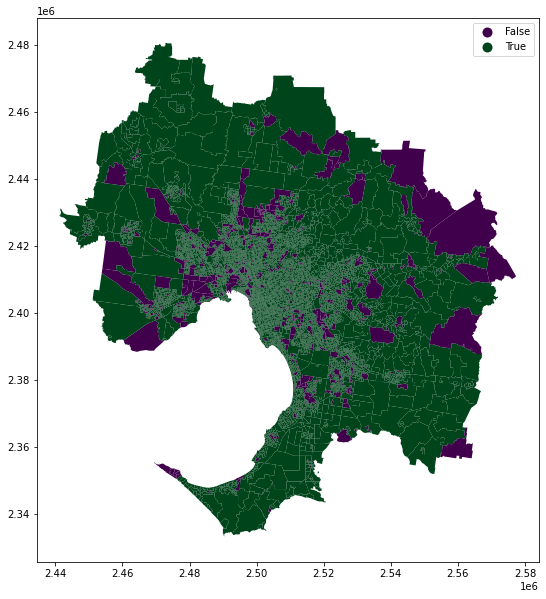

In [56]:
shp_path = 'Data/Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = caclulated_name
attr_table = influx_affluent_06_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

In [ ]:
#influx_affluent_06_16.to_csv('Data/Gentrification_Labels/Educational_Attainment/EA_06_16_SA1_outcome.csv',index=False)

# 4. Low-Income Households <a name="li_hh"></a>

Have a median income less than the median (40th percentile) for that metropolitan area at the beginning of the intercensal period.
Data: 
- Median_total_household_income_weekly (2006)
- Median household income ($/week) (2011)


## 2011-2016

In [57]:
filter_units_path = 'Data/Geographical_Units/Great_Melbourne_Units/SA1_2016_GM.csv'
attr_file_path = 'Data/Gentrification_Labels/Income/Geopandas_Interpolated/Income_2011.csv'
attr_name = 'Income'
calculated_attr = 'low_income'
columns = [1,2]
code = 1
quantile = 0.4

In [58]:
# Function to do a binary classification given a quantile threshold in a numerical feature

def quantile_threshold_classify(attr_file_path, columns, filter_units_path, attr_name, quantile, 
                                calculated_attr, code=0):
    
    trimmed_attr = load_trim_attr(attr_file_path, 
                                  columns, 
                                  filter_units_path, 
                                  attr_name, 
                                  code=code)
    
    trim_attr_quantile = trimmed_attr[attr_name].quantile(quantile)
    trimmed_attr[calculated_attr] = np.where(trimmed_attr[attr_name]< trim_attr_quantile, True, False)
    
    #Print results
    print('tracts with '+ caclulated_name + ' ' \
          + str(len(trimmed_attr[trimmed_attr[calculated_attr] == True])))
    print('tracts without '+ caclulated_name + ' ' \
          + str(len(trimmed_attr[trimmed_attr[calculated_attr] == False])))
    
    return trimmed_attr

In [59]:
income_11_16 = quantile_threshold_classify (attr_file_path, 
                                            columns, 
                                            filter_units_path, 
                                            attr_name, 
                                            quantile, 
                                            calculated_attr, 
                                            code= code)

tracts with Influx_affluent 4116
tracts without Influx_affluent 6173


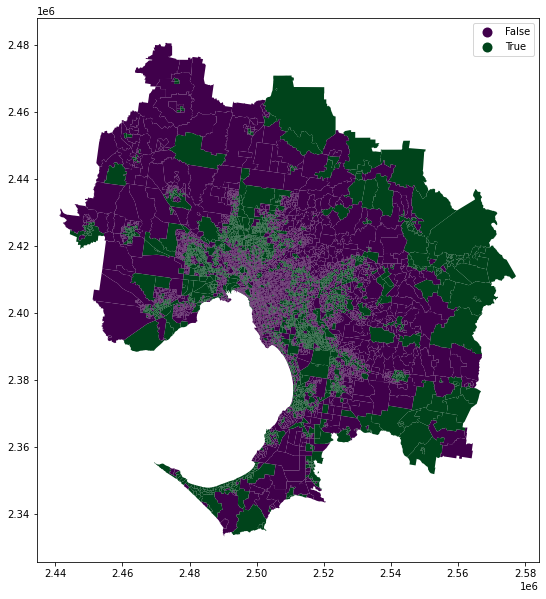

In [60]:
shp_path = 'Data/Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = calculated_attr
attr_table = income_11_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

## 2006-2016

In [61]:
filter_units_path = 'Data/Geographical_Units/Great_Melbourne_Units/SA1_2016_GM.csv'
attr_file_path = 'Data/Gentrification_Labels/Income/Geopandas_Interpolated/Income_2006.csv'
attr_name = 'Income'
calculated_attr = 'low_income'
columns = [1,2]
code = 1
quantile = 0.4

In [62]:
income_06_16 = quantile_threshold_classify (attr_file_path, 
                                            columns, 
                                            filter_units_path, 
                                            attr_name, 
                                            quantile, 
                                            calculated_attr, 
                                            code= code)

tracts with Influx_affluent 4116
tracts without Influx_affluent 6173


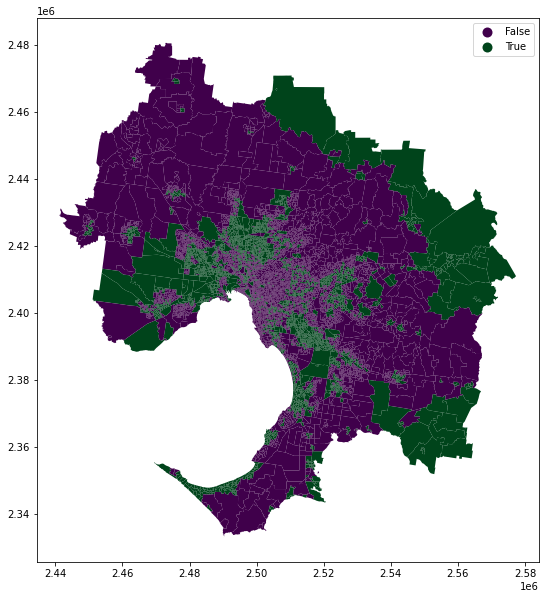

In [63]:
shp_path = 'Data/Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = calculated_attr
attr_table = income_06_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

# 5. Reinvestment <a name="reinv"></a>

Any increae in house prices is considered a proxy of investment. The source files contain selling prices of houses in Melbourne, though unit/apartment prices are also available.

In [64]:
# Function to iterate over csv files in a directory

def load_csv_in_carpet(rootdir, mask_path, year):
    counter =  1
    for subdir, dirs, files in os.walk(rootdir):
        
        for file in files:
            
            filepath = subdir + os.sep + file
            if filepath.endswith(".csv"):
                
                attr_name = year+'_'+str(counter)
                if counter == 1:
                    
                    merging_table = load_trim_attr(filepath, 
                                                   [0,1], 
                                                   mask_path, 
                                                   attr_name, 
                                                   code=0)
                else:
                    
                    new_df = load_trim_attr(filepath, 
                                            [0,1], 
                                            mask_path, 
                                            attr_name, 
                                            code=0)
                    merging_table[attr_name] = pd.to_numeric(new_df[attr_name])
                    
                counter = counter + 1
                merging_table = merging_table[merging_table.columns[0:counter]]

    attrs_fillna = merging_table[merging_table.columns[1:counter]]. \
                   apply(lambda row: row.fillna(row.mean()), axis=1)
    
    result = pd.concat([merging_table[merging_table.columns[0]], attrs_fillna], axis=1, join="inner") 
    result['mean_'+year] = result.iloc[:, 1:counter].mean(axis=1)
    result.fillna(result.mean(), inplace =True)
    
    return result

In [65]:
# Calculate the median of property values in 2016

rootdir = 'Data/Gentrification_Labels/House_Prices/2016'
mask_path = 'Data/Geographical_Units/Great_Melbourne_Units/SA2_2011_GM.csv'
year = '2016'

house_median_2016 = load_csv_in_carpet(rootdir, 
                                       mask_path, 
                                       year)

In [66]:
#house_median_2016.to_csv('Data/Gentrification_Labels/House_Prices/mean_median_SA2_2011/house_prices_2016.csv',index=False)

In [68]:
# Calculate the median of property values in 2011

rootdir = 'Data/Gentrification_Labels/House_Prices/2011'
mask_path = 'Data/Geographical_Units/Great_Melbourne_Units/SA2_2011_GM.csv'
year ='2011'

house_median_2011 = load_csv_in_carpet(rootdir, 
                                       mask_path, 
                                       year)

In [ ]:
#house_median_2011.to_csv('Data/Gentrification_Labels/House_Prices/mean_median_SA2_2011/house_prices_2011.csv',index=False)

In [69]:
# Calculate the median of property values in 2006

rootdir = 'Data/Gentrification_Labels/House_Prices/2006'
mask_path = 'Data/Geographical_Units/Great_Melbourne_Units/SA2_2011_GM.csv'
year ='2006'

house_median_2006 = load_csv_in_carpet(rootdir, 
                                       mask_path, 
                                       year)

In [70]:
#house_median_2006.to_csv('Data/Gentrification_Labels/House_Prices/mean_median_SA2_2011/house_prices_2006.csv',index=False)

Some SA2 do not posess information on selling prices of houses in one, two or even the three years. Since the trend of house prices in Melbourne has shown a particularly increasing behaviour, we have shosen to fill those blank spaces with the mean of that year. The impact that this assumptions makes should not be perjudicial as it is generally safe to assume most parts of the city have witnessed a rise in prices for the past 20 years.

Interpolation of those values from SA2_2011 to SA2_2016 is required. It is performed with the notebook: "Areal_Interpolation"

In [71]:
df_mean_2006 = read_table('Data/Gentrification_Labels/House_Prices/Geopandas_Interpolated/House_Price_2006.csv')
df_mean_2011 = read_table('Data/Gentrification_Labels/House_Prices/Geopandas_Interpolated/House_Price_2011.csv')
df_mean_2016 = read_table('Data/Gentrification_Labels/House_Prices/Geopandas_Interpolated/House_Price_2016.csv')

HV_all_years = pd.concat([df_mean_2006[['SA1_MAINCO','SA1_7DIG16','House_Price_2006']],
                                   df_mean_2011[['House_Price_2011']],
                                   df_mean_2016[['House_Price_2016']]],
                                   axis=1, join="inner") 

HV_all_years.fillna(0, inplace=True)

In [72]:
def house_value_increase(df, start_column, end_column, calculated_attr):
    
    df[calculated_attr] = np.where(df[end_column]>= df[start_column], True, False)
    
    print('tracts with increased house prices ' + str(len(df[df[calculated_attr] == True])))
    print('tracts without increased house prices '  + str(len(df[df[calculated_attr] == False])))
    
    return df

### 2011-2016

In [73]:
reinvestment_11_16 = house_value_increase(HV_all_years, 
                                          'House_Price_2011', 
                                          'House_Price_2016', 
                                          'increased_11_16')

tracts with increased house prices 9984
tracts without increased house prices 305


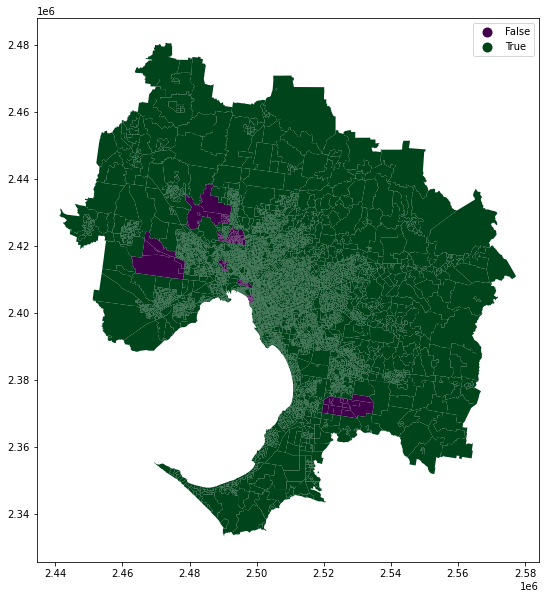

In [75]:
shp_path = 'Data/Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = 'increased_11_16'
attr_table = reinvestment_11_16
attr_pivot_col = 'SA1_7DIG16'
shp_pivot_col = 'SA1_7DIG16'

plot_categorical_attr(shp_path, 
                      crs, attribute, 
                      attr_table, 
                      attr_pivot_col, 
                      shp_pivot_col)

### 2006-2016

In [76]:
reinvestment_06_16 = house_value_increase(HV_all_years, 
                                          'House_Price_2006', 
                                          'House_Price_2016', 
                                          'increased_06_16')

tracts with increased house prices 10260
tracts without increased house prices 29


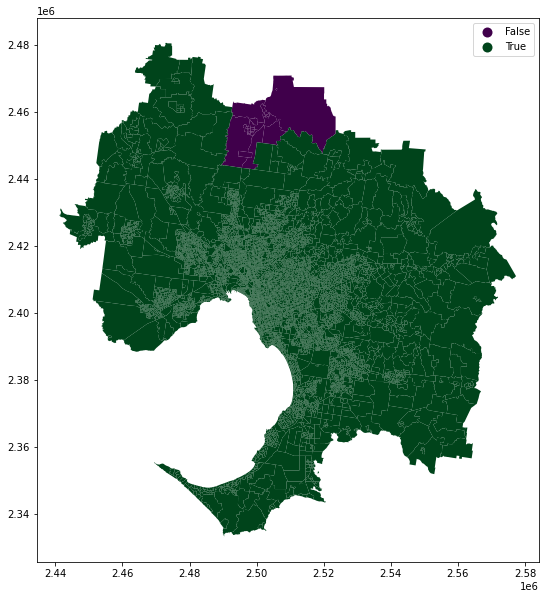

In [77]:
shp_path = 'Data/Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = 'increased_06_16'
attr_table = reinvestment_06_16
attr_pivot_col = 'SA1_7DIG16'
shp_pivot_col = 'SA1_7DIG16'

plot_categorical_attr(shp_path, 
                      crs, 
                      attribute, 
                      attr_table, 
                      attr_pivot_col, 
                      shp_pivot_col)

# 6. Results: Gentrification Classification <a name="results"></a>

This section of the Notebook uses the past dataframes related to Freeman's criteria for gentrifiedd areas to determine Melbournes binary gentrification status.

## 2006-2016

In [86]:
#Join all previous dataframes

final_label_06_16 = building_permits[['SA1_MAINCO','Disinvested']]

final_label_06_16 = merge_str(final_label_06_16, 
                              income_06_16[['SA1_7DIG16','SA1_MAINCODE_2016','low_income']],
                              'SA1_MAINCO', 
                              'SA1_MAINCODE_2016', 
                              'right')

final_label_06_16 = merge_str(final_label_06_16, 
                              influx_affluent_06_16[['SA1_7DIG16', 'Influx_affluent']], 
                              'SA1_7DIG16',
                              'SA1_7DIG16', 
                              'left')

final_label_06_16 = merge_str(final_label_06_16, 
                              reinvestment_06_16[['SA1_7DIG16', 'increased_06_16']],
                              'SA1_7DIG16',
                              'SA1_7DIG16', 
                              'left')

final_label_06_16['Gentrified_06_16'] = final_label_06_16['Disinvested'] \
                                        & final_label_06_16['low_income']  \
                                        & final_label_06_16['Influx_affluent'] \
                                        & final_label_06_16['increased_06_16']

In [89]:
#final_label_06_16.to_csv('Data/Gentrification_Labels/labels_2006_2016.csv')

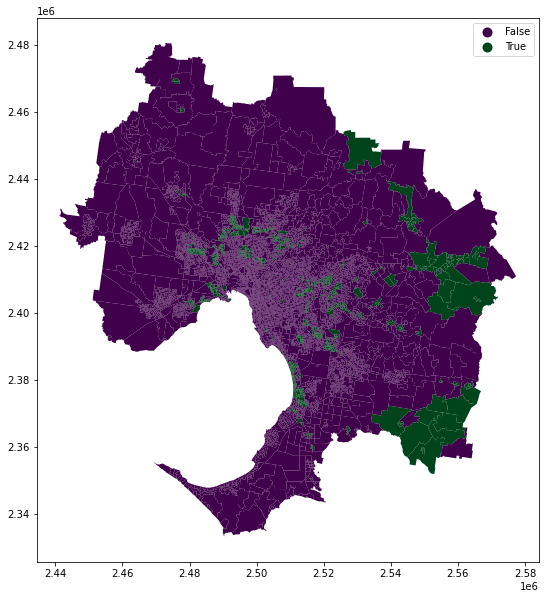

In [87]:
shp_path = 'Data/Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = 'Gentrified_06_16'
attr_table = final_label_06_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'

plot_categorical_attr(shp_path, 
                      crs, 
                      attribute, 
                      attr_table, 
                      attr_pivot_col, 
                      shp_pivot_col)

## 2011-2016

In [90]:
#Join all previous dataframes

final_label_11_16 = building_permits[['SA1_MAINCO','Disinvested']]

final_label_11_16 = merge_str(final_label_11_16, 
                              income_11_16[['SA1_7DIG16','SA1_MAINCODE_2016','low_income']],
                              'SA1_MAINCO', 
                              'SA1_MAINCODE_2016', 
                              'right')

final_label_11_16 = merge_str(final_label_11_16, 
                              influx_affluent_11_16[['SA1_7DIG16', 'Influx_affluent']], 
                              'SA1_7DIG16',
                              'SA1_7DIG16', 
                              'left')

final_label_11_16 = merge_str(final_label_11_16, 
                              reinvestment_11_16[['SA1_7DIG16', 'increased_11_16']],
                              'SA1_7DIG16',
                              'SA1_7DIG16', 
                              'left')

final_label_11_16['Gentrified_11_16'] = final_label_11_16['Disinvested'] \
                                        & final_label_11_16['low_income']  \
                                        & final_label_11_16['Influx_affluent'] \
                                        & final_label_11_16['increased_11_16']

In [91]:
#final_label_11_16.to_csv('Data/Gentrification_Labels/labels_2011_2016.csv')

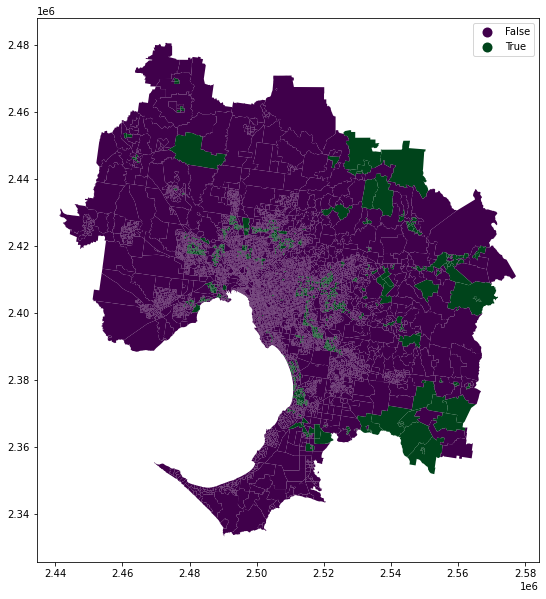

In [94]:
shp_path = 'Data/Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = 'Gentrified_11_16'
attr_table = final_label_11_16
attr_pivot_col = 'SA1_7DIG16'
shp_pivot_col = 'SA1_7DIG16'

plot_categorical_attr(shp_path, 
                      crs, 
                      attribute, 
                      attr_table, 
                      attr_pivot_col, 
                      shp_pivot_col)